# Resume Parsing

So basically, we want to create a entity ruler to parse real resume and get the "skills".

But for your assignment, i will ask you to extract education.

## 1. Load data

In [1]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("resume.csv")

In [2]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]  #optional if your computer is fast, no need
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [7]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = "skills.jsonl"

In [8]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [9]:
doc = nlp("Chaky loves deep learning.")
doc.ents

(Chaky, deep learning)

## 3. Let's try to extract skills from this resume.csv

In [10]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
1975,39674782,CONSTRUCTION DEVELOPMENT CONSULTANT ...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION
1519,24411323,FINANCE MANAGER Summary Top\...,"<div class=""fontsize fontface vmargins hmargin...",FINANCE
375,36569713,TEACHER Summary Teacher...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER
816,38642923,CERTIFIED PERSONAL TRAINER AND GROUP ...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS
1323,28790806,DATASTAGE ETL DEVELOPER Summary...,"<div class=""fontsize fontface vmargins hmargin...",AUTOMOBILE


In [11]:
from spacy.lang.en.stop_words import STOP_WORDS

#before that, let's clean our resume.csv dataframe
def preprocessing(sentence):
    
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

In [12]:
#let's try Chaky, if you feel too dangerous
#random sampling
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         SENIOR FIELD APPLICATION SPECIALIST       Summary    Senior Field Application Specialist with extensive customer training experience for a large, international, biotech company. An expert on multiple In Vitro Diagnostic systems and microbial methodologies, all utilized by laboratories in th'

In [13]:
preprocessing(random_resume[:300])

'senior field application specialist summary senior field application specialist extensive customer training experience large international biotech company an expert multiple in vitro diagnostic system microbial methodology utilize laboratory th'

In [14]:
#let's apply to the whole dataframe
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [15]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
1975,39674782,CONSTRUCTION DEVELOPMENT CONSULTANT ...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,construction development consultant summary di...
1519,24411323,FINANCE MANAGER Summary Top\...,"<div class=""fontsize fontface vmargins hmargin...",FINANCE,finance manager summary top perform individual...
375,36569713,TEACHER Summary Teacher...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER,teacher summary teacher devote help child thin...
816,38642923,CERTIFIED PERSONAL TRAINER AND GROUP ...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS,certified personal trainer and group fitness i...
1323,28790806,DATASTAGE ETL DEVELOPER Summary...,"<div class=""fontsize fontface vmargins hmargin...",AUTOMOBILE,datastage etl developer summary i 6 year etl e...


## 4. Let's really extract skills!!

In [16]:
def get_skills(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills
    
    skills = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "SKILL":
            skills.append(ent.text)
    
    return skills

def unique_skills(x):
    return list(set(x))

In [17]:
df_resume.head(1)

,ID,Resume_str,Resume_html,Category,Clean_resume
1975,39674782,CONSTRUCTION DEVELOPMENT CONSULTANT ...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,construction development consultant summary di...


In [18]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [19]:
df_resume.Skills.iloc[0]

['specification',
 'business',
 'material',
 'software',
 'design',
 'engineering',
 'realm',
 'project management']

## 5. Visualization

Which skills is most important in information management?

In [20]:
set(df_resume.Category)

{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [21]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(45, 6)

In [22]:
all_skill = np.concatenate(df_resume_it.Skills.values)

In [23]:
#counting
from collections import Counter, OrderedDict

counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

In [24]:
counting

OrderedDict([('support', 41),
             ('software', 37),
             ('design', 34),
             ('security', 33),
             ('business', 30),
             ('server', 30),
             ('windows', 28),
             ('database', 25),
             ('project management', 22),
             ('help desk', 17)])

<BarContainer object of 10 artists>

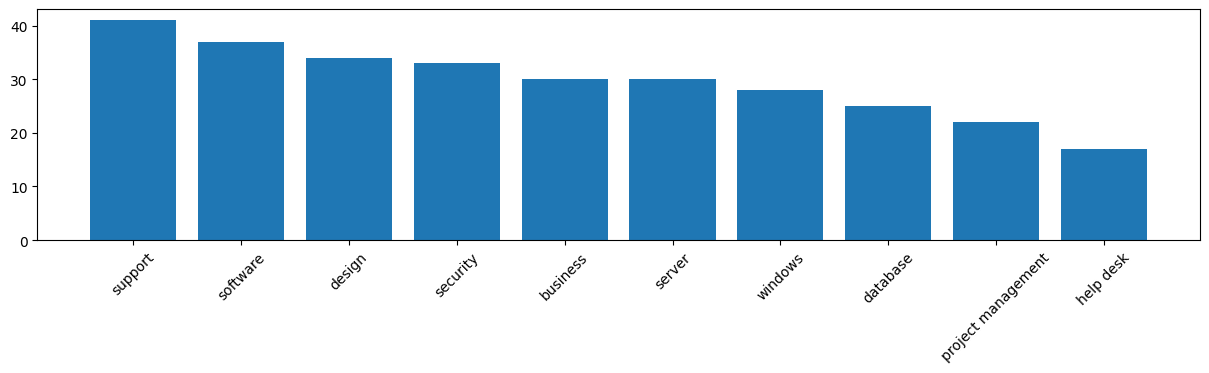

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation =45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [26]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[43]

In [27]:
doc = nlp(text)

In [28]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [32]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

## 7. Let's load the PDF - add some realism

In [29]:
# !pip install PyPDF2

In [58]:
from PyPDF2 import PdfReader
# pip install PyPDF2
path = '/Users/atichetsurakul/Desktop/JAN23/RTML/lecturesession/5/yolo.pdf'
reader = PdfReader(path)
page = reader.pages[-4] #first page just for demo
text = page.extract_text() 

In [59]:
# text

In [60]:
doc = nlp(text)
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)